In [1]:
import os
import re

# Pre-requisites
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns



# Store the classifier models
import joblib

import missingno as msno
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, SMOTENC

# Classifiers from scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# Performance metrics
from sklearn.metrics import accuracy_score, cohen_kappa_score, auc, average_precision_score, f1_score, precision_recall_curve, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

from scipy.stats import pointbiserialr
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('data/ready_df_with_dep.csv')
df.head()

,Quarter,Month,DayofMonth,DayOfWeek,Reporting_Airline,Origin,Dest,DepDelay,DepDel15,DepTimeBlk,...,dep_time_shift_sin,dep_time_shift_cos,is_night_departure,is_evening_departure,low_visibility,strong_wind,wind_gust,bad_weather_score,is_hub_route,is_roundtrip
0,1,1,1,1,AA,SDF,MIA,0.0,0.0,0001-0559,...,0.000000,0.000000,0,0,0,0,0,0,0,1
1,1,1,1,1,NK,SDF,LAS,-7.0,0.0,0600-0659,...,-0.000466,0.030539,0,0,0,0,0,0,0,1
2,1,1,1,1,DL,SDF,ATL,-4.0,0.0,0600-0659,...,-0.000152,0.017452,0,0,0,0,0,0,1,1
3,1,1,1,1,WN,SDF,MCO,-4.0,0.0,0600-0659,...,0.000228,0.017452,0,0,0,0,0,0,0,1
4,1,1,1,1,AA,SDF,CLT,18.0,1.0,0600-0659,...,-0.009229,-0.077975,0,0,0,0,0,0,1,1


In [3]:
cols_no_dep = ["DepDel15", "dep_delay_gt30", "dep_delay_gt60","DepTime_sin", "DepTime_cos","WheelsOff_sin", "WheelsOff_cos","dep_time_shift_sin", "dep_time_shift_cos", "DepDelay", "TaxiOut","dep_delay_ratio", "taxiout_long", "dep_delay_ratio"]
df = df.drop(columns=['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'ArrDelayMinutes'])
df = df.drop(columns=cols_no_dep)

In [4]:
df.shape

(47518, 41)

---

# Scaling and encoding (OHE)

In [5]:
num_features = ["bad_weather_score", "CRSElapsedTime", "Distance", "DistanceGroup", "HourlyDewPointTemperature", "HourlyDryBulbTemperature", "HourlyPrecipitation", "HourlyRelativeHumidity", "HourlySeaLevelPressure", "HourlyVisibility", "HourlyWindGustSpeed", "HourlyWindSpeed", "wind_dir_sin", "wind_dir_cos", "CRSArrTime_sin", "CRSArrTime_cos", "CRSDepTime_sin", "CRSDepTime_cos", "Quarter_sin", "Quarter_cos", "Month_sin", "Month_cos", "DayofMonth_sin", "DayofMonth_cos", "DayOfWeek_sin", "DayOfWeek_cos"]

cat_features = ["Reporting_Airline", "Origin", "Dest", "DepTimeBlk", "HourlyWeatherType", "HourlySkyCondit"]

pass_features = ["is_night_departure", "is_evening_departure", "low_visibility", "strong_wind", "wind_gust", "is_hub_route", "is_roundtrip", "wind_dir_vrb"]

In [6]:
len(num_features + cat_features + pass_features)

40

In [7]:
X = df.drop(columns=['ArrDel15'], axis=1)
y = df['ArrDel15'].copy()
X.shape, y.shape

((47518, 40), (47518,))

In [8]:
y.value_counts()

ArrDel15
0.0    38350
1.0     9168
Name: count, dtype: int64

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features),
        ('bin', 'passthrough', pass_features),
    ]
)

In [11]:
def make_pipe(model, use_smote=False, use_fs=False, k=209, random_state=33):
    steps = [("preprocess", preprocessor)]
    
    if use_fs:
        steps.append(("select", SelectKBest(score_func=f_classif, k=k)))
        
    if use_smote:
        steps.append(("smote", SMOTE(random_state=random_state)))
        steps.append(("model", model))
        return ImbPipeline(steps)
    else:
        steps.append(("model", model))
        return Pipeline(steps)

---

In [12]:
X_train_encoded = preprocessor.fit_transform(X_train, y_train)
X_valid_encoded = preprocessor.transform(X_valid)

X_train_encoded_smote, y_train_smote = SMOTE().fit_resample(X_train_encoded, y_train)

ohe = preprocessor.named_transformers_['cat']
cat_ohe_names = ohe.get_feature_names_out(cat_features)

final_feature_names = (
        np.array(num_features, dtype=object).tolist()
        + cat_ohe_names.tolist()
        + pass_features
)
print("Final feature count:", len(final_feature_names))
#print("Example names:", final_feature_names[50:])
X_train_encoded = pd.DataFrame(X_train_encoded, columns=final_feature_names, index=X_train.index)
X_valid_encoded = pd.DataFrame(X_valid_encoded, columns=final_feature_names, index=X_valid.index)

X_train_encoded_features = X_train_encoded.columns.tolist()

Final feature count: 150


---

---

## Save model function

In [14]:
def save_model(model_name, grid, scores_df, scoring, rs, num_cv):
    """
    Save the trained model artifact along with metadata to disk.

    The function stores the best estimator obtained from GridSearchCV,
    its best hyperparameters, cross-validation results, evaluation scores,
    and configuration details into a single artifact file using joblib.

    Args:
        model_name (str): Name of the model used for saving the artifact file.
        grid (GridSearchCV): Fitted GridSearchCV object containing the best estimator.
        scores_df (pandas.DataFrame): DataFrame with evaluation metrics.
        scoring (str): Scoring metric used during model selection.
        rs (int): Random state used for reproducibility.
        num_cv (int): Number of cross-validation splits.

    Returns:
        None
    """
    
    artifact = {
        "model": grid.best_estimator_,
        "best_params": grid.best_params_,
        "cv_results": grid.cv_results_,
        "scores_df": scores_df,
        "scoring": scoring,
        "random_state": rs,
        "cv_splits": num_cv
    }

    joblib.dump(artifact, f"models/classif_no_dep/{model_name}_NO_Dep_artifact.joblib")

## Validation curves function

In [15]:
def plot_fixed_param_curve(grid, vary_key, title, xlabel, xscale="linear", markers=True, save=False,
                           save_dir="img/classif_no_dep/val_curves", dpi=300, fmt='png'):
    """
    Plot a validation curve for a single hyperparameter while keeping other parameters fixed.

    The function extracts cross-validation results from a fitted GridSearchCV object,
    filters configurations where all parameters except the selected one match the
    best parameters, and visualizes train and validation scores with standard
    deviation bands.

    Args:
        grid (GridSearchCV): Fitted GridSearchCV object containing cv_results_.
        vary_key (str): Name of the hyperparameter to analyze.
        title (str): Plot title.
        xlabel (str): Label for the x-axis.
        xscale (str, optional): Scale of the x-axis ("linear", "log", etc.).
            Defaults to "linear".
        markers (bool, optional): Whether to display markers on the curves.
            Defaults to True.
        save (bool, optional): Whether to save the plot to disk.
            Defaults to False.
        save_dir (str, optional): Directory where the plot will be saved.
            Defaults to "validation_curves".
        dpi (int, optional): Resolution of the saved figure.
            Defaults to 300.
        fmt (str, optional): File format for saving the figure (e.g., "png", "jpg").
            Defaults to "png".

    Returns:
        None
    """
    
    cvres = grid.cv_results_
    params_list = cvres["params"]
    best_params = grid.best_params_.copy()

    mask = []
    for p in params_list:
        ok = True
        for k, v in best_params.items():
            if k == vary_key:
                continue
            if p.get(k) != v:
                ok = False
                break
        mask.append(ok)
    mask = np.array(mask, dtype=bool)

    x_vals = np.array([params_list[i][vary_key] for i in range(len(params_list)) if mask[i]])

    train_mean = np.array(cvres["mean_train_score"])[mask]
    train_std  = np.array(cvres["std_train_score"])[mask]
    val_mean   = np.array(cvres["mean_test_score"])[mask]
    val_std    = np.array(cvres["std_test_score"])[mask]

    order = np.argsort(x_vals.astype(float))
    x_vals = x_vals[order]
    train_mean, train_std = train_mean[order], train_std[order]
    val_mean, val_std     = val_mean[order], val_std[order]

    best_x = grid.best_params_[vary_key]

    # marker style
    marker_style = 'o' if markers else None
    
    plt.figure(figsize=(9, 5))
    plt.plot(x_vals, train_mean, marker=marker_style, label="Train (mean)")
    plt.fill_between(x_vals, train_mean - train_std, train_mean + train_std, alpha=0.2)

    plt.plot(x_vals, val_mean, marker=marker_style, label="CV (mean)")
    plt.fill_between(x_vals, val_mean - val_std, val_mean + val_std, alpha=0.2)

    plt.axvline(best_x, linestyle="--", linewidth=1, label=f"Best = {best_x}")

    plt.xscale(xscale)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Average precision")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    
    if save:
        os.makedirs(save_dir, exist_ok=True)

        safe_title = title.lower().replace(" ", "_").replace(":", "")
        fname = f"{safe_title}_NO_Dep_{vary_key}.{fmt}"
        path = os.path.join(save_dir, fname)

        plt.savefig(path, dpi=dpi, bbox_inches="tight")
        print(f"Saved plot → {path}")
        
    plt.show()

## Evaluation Function

In [16]:
def model_evaluation(model_name, best_estimator, X_valid_prepared, y_valid, threshold=0.5, tune_threshold=False, clas_report=False, pr_curve_plot=False, conf_matr = False, save_pr=False, save_pr_dir='img/classif_no_dep/pr_curves', fmt='png', dpi=300, save_conf=False, save_conf_dir='img/classif_no_dep/conf_matrix'):
    """
    Evaluate a trained classification model on validation (hold-out) data.

    This function computes standard classification metrics, optionally tunes
    the decision threshold based on F1-score, and can visualize the confusion
    matrix and Precision–Recall curve. It also supports saving plots to disk.

    Args:
        model_name (str): Name of the model (used for display and filenames).
        best_estimator: Trained classifier with `predict_proba` method.
        X_valid_prepared (array-like or DataFrame): Preprocessed validation features.
        y_valid (array-like or Series): True validation labels.
        threshold (float, optional): Probability threshold for classification.
            Defaults to 0.5.
        tune_threshold (bool, optional): If True, finds the threshold that
            maximizes F1-score on validation data. Defaults to False.
        clas_report (bool, optional): If True, prints classification report.
        pr_curve_plot (bool, optional): If True, plots Precision–Recall curve.
        conf_matr (bool, optional): If True, plots confusion matrix.
        save_pr (bool, optional): If True, saves PR curve plot.
        save_pr_dir (str, optional): Directory to save PR curve.
        fmt (str, optional): File format for saved plots (e.g., "png", "jpg").
        dpi (int, optional): DPI for saved plots.
        save_conf (bool, optional): If True, saves confusion matrix plot.
        save_conf_dir (str, optional): Directory to save confusion matrix.

    Returns:
        pd.DataFrame: DataFrame containing evaluation metrics for the model.
    """
    
    y_pred_proba = best_estimator.predict_proba(X_valid_prepared)[:, 1]
    
    if tune_threshold:
        ths = np.linspace(0.05, 0.95, 181)
        f1s = [f1_score(y_valid, (y_pred_proba >= t).astype(int)) for t in ths]
        threshold = ths[int(np.argmax(f1s))]

    y_pred = (y_pred_proba >= threshold).astype(int)
    
    acc = accuracy_score(y_valid, y_pred)
    prec = precision_score(y_valid, y_pred, zero_division=0)
    rec = recall_score(y_valid, y_pred, zero_division=0)
    f1 = f1_score(y_valid, y_pred, zero_division=0)
    av_prec = average_precision_score(y_valid, y_pred_proba, average='weighted')
    roc_auc = roc_auc_score(y_valid, y_pred_proba)
    kappa = cohen_kappa_score(y_valid, y_pred)
    
    scores_dict = {
        'Accuracy': acc*100,
        'Precision': prec*100,
        'Recall': rec*100,
        'F1': f1,
        'Kappa': kappa,
        'ROC_AUC': roc_auc,
        'PR_AUC': av_prec,
    }
    for name, score in scores_dict.items():
        scores_dict[name] = round(score, 3)
    
    print(f"\n--- Validation metrics - {model_name} - No departure --")
    scores_df = pd.DataFrame(data=scores_dict, index=[model_name])
    
    if conf_matr:
        cm = confusion_matrix(y_valid, y_pred)
        #labels = ["OnTime", "Delayed"]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',)
                    #xticklabels=[f"Pred {l}" for l in labels],
                    #yticklabels=[f"True{l}" for l in labels])
        plt.xlabel("PRED")
        plt.ylabel("TRUE")
        plt.title(f"Confusion Matrix for {model_name} - No Departure")
        
        # Class legend
        plt.text(
            1.05, -0.1,
            "Class mapping:\n0 — OnTime\n1 — Delayed",
            transform=plt.gca().transAxes,
            fontsize=10,
            verticalalignment="center",
        )
        plt.tight_layout()
        
        if save_conf:
            os.makedirs(save_conf_dir, exist_ok=True)
            safe_name = model_name.lower().replace(" ", "_").replace("/", "_")
            filename = f"{safe_name}_conf_matrix_holdout_no_dep.{fmt}"
            path = os.path.join(save_conf_dir, filename)
            plt.savefig(path, dpi=dpi, bbox_inches="tight")
            print(f"Saved plot → {path}")
        plt.show()
    
    if clas_report:
        print(classification_report(y_valid, y_pred))
    
    if pr_curve_plot:
        precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba)
        ap = average_precision_score(y_valid, y_pred_proba)

        pos_rate = np.mean(y_valid)

        eps = 1e-12

        def fbeta(p, r, beta):
            b2 = beta**2
            return (1 + b2) * p * r / (b2 * p + r + eps)

        # scores
        f1  = fbeta(precision, recall, beta=1.0)
        f05 = fbeta(precision, recall, beta=0.5)  # precision in focus
        f2  = fbeta(precision, recall, beta=2.0)  # recall in focus

        # best indices
        idx_f1  = np.argmax(f1)
        idx_f05 = np.argmax(f05)
        idx_f2  = np.argmax(f2)

        # points
        points = [
            ("Best F1",   idx_f1,  f1[idx_f1]),
            ("Best F0.5", idx_f05, f05[idx_f05]),
            ("Best F2",   idx_f2,  f2[idx_f2]),
        ]

        plt.figure(figsize=(7, 5))
        plt.plot(recall, precision, lw=2, label=f"PR curve (AP = {ap:.3f})")
        plt.axhline(pos_rate, linestyle="--", lw=1, label=f"Baseline = {pos_rate:.3f}")

        # draw points + annotations
        for name, idx, score in points:
            p_i, r_i = precision[idx], recall[idx]
            plt.scatter(r_i, p_i, s=90, zorder=5, label=f"{name} = {score:.3f}")
            plt.annotate(
                f"{name}\nP={p_i:.3f}\nR={r_i:.3f}",
                (r_i, p_i),
                textcoords="offset points",
                xytext=(10, 0),
                fontsize=9,
                arrowprops=dict(arrowstyle="->")
            )

        plt.title(f"{model_name} — Precision–Recall curve [hold-out] - no dep")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.legend()
        plt.tight_layout()
        
        if save_pr:
            os.makedirs(save_pr_dir, exist_ok=True)
            safe_name = model_name.lower().replace(" ", "_").replace("/", "_")
            filename = f"{safe_name}_pr_curve_holdout_no_dep.{fmt}"
            path = os.path.join(save_pr_dir, filename)
            plt.savefig(path, dpi=dpi, bbox_inches="tight")
            print(f"Saved plot → {path}")
        
        plt.show()
    
    return scores_df

## Save trees from DT and XGB

In [18]:
from dtreeviz import model
def save_dtreeviz_tree_from_pipeline(
    pipe,
    X_train,
    y_train,
    *,
    class_names=("OnTime", "Delayed"),
    target_name="target",
    max_depth=4,
    save_path="trees/tree_no_dep_best.svg",
    tree_index=0
):
    
    """
    Visualize and save a decision tree from a fitted sklearn Pipeline using dtreeviz.

    The function extracts the preprocessing step and trained model from the
    pipeline, transforms the training data, retrieves the correct feature
    names (including those generated by OneHotEncoder), and generates a
    dtreeviz visualization. The resulting tree is saved as an SVG file.

    Args:
        pipe (Pipeline): Fitted sklearn Pipeline containing:
            - "preprocess" step (e.g., ColumnTransformer)
            - "model" step (DecisionTreeClassifier or RandomForestClassifier).
        X_train (DataFrame or array-like): Training feature data (before preprocessing).
        y_train (Series or array-like): Training target labels.
        class_names (tuple, optional): Class labels for visualization.
            Defaults to ("OnTime", "Delayed").
        target_name (str, optional): Name of the target variable in the plot.
            Defaults to "target".
        max_depth (int, optional): Maximum tree depth to display in visualization.
            Defaults to 4.
        save_path (str, optional): File path to save the SVG visualization.
            Defaults to "trees/dtree_best.svg".
        tree_index (int, optional): Index of the tree (used for ensembles like
            RandomForest). Defaults to 0.

    Returns:
        str: Path to the saved SVG file.
    """

    preprocess = pipe.named_steps["preprocess"]
    clf = pipe.named_steps["model"]

    # X that the tree actually sees
    X_vis = preprocess.transform(X_train)
    if not isinstance(X_vis, np.ndarray):
        X_vis = np.asarray(X_vis)
    
    # Correct feature names after ColumnTransformer + OHE
    feature_names = list(preprocess.get_feature_names_out())

    # Safety: if mismatch, fallback to f0..fN
    if len(feature_names) != X_vis.shape[1]:
        feature_names = [f"f{i}" for i in range(X_vis.shape[1])]

    y_vis = np.asarray(y_train).astype(int)
    
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    viz = model(
        clf,
        X_train=X_vis,
        y_train=y_vis,
        feature_names=feature_names,
        target_name=target_name,
        class_names=list(class_names),
        tree_index=int(tree_index)
    )

    v = viz.view(depth_range_to_display=[0, max_depth])
    v.save(save_path)
    return save_path

## Feature Importances for RF and XGB

In [17]:
def _ensure_dir(path: str):
    if path is None:
        return
    os.makedirs(os.path.dirname(path), exist_ok=True)

def _get_feature_names(feature_names=None, X=None):
    """
    Resolve feature names in this priority:
    1) explicit feature_names
    2) X.columns if DataFrame
    3) fallback: f0..f{n-1} if X is array-like
    """
    if feature_names is not None:
        return list(feature_names)
    if X is not None and hasattr(X, "columns"):
        return list(X.columns)
    if X is not None and hasattr(X, "shape"):
        return [f"f{i}" for i in range(X.shape[1])]
    return None

def _extract_model(obj, model_step_name="model"):
    """
    If obj is a Pipeline, return its last estimator (or named step).
    Otherwise return obj.
    """
    if hasattr(obj, "named_steps"):
        if model_step_name in obj.named_steps:
            return obj.named_steps[model_step_name]
        # fallback: last step
        return obj.steps[-1][1]
    return obj

def _xgb_importance(model, importance_type="gain", feature_names=None, X=None):
    """
    Extract importance from xgboost model/booster in a robust way.
    - supports sklearn API (XGBClassifier/Regressor) and Booster
    - returns aligned array of importances and names
    """
    # Get booster
    booster = None
    if hasattr(model, "get_booster"):
        booster = model.get_booster()
    elif hasattr(model, "feature_names") or hasattr(model, "get_score"):
        booster = model  # assume Booster-like

    if booster is None or not hasattr(booster, "get_score"):
        raise ValueError("Cannot extract XGB importance: booster not found.")

    score_dict = booster.get_score(importance_type=importance_type)  # keys like 'f0','f1',...
    if not score_dict:
        raise ValueError(
            "XGB importance is empty. Model might be unfitted or importance_type produced no scores."
        )

    # Resolve names
    names = _get_feature_names(feature_names=feature_names, X=X)
    if names is None:
        # try booster feature_names
        if getattr(booster, "feature_names", None):
            names = list(booster.feature_names)
        else:
            # infer max index from keys
            max_i = max(int(k[1:]) for k in score_dict.keys() if k.startswith("f"))
            names = [f"f{i}" for i in range(max_i + 1)]

    # Build array aligned to names
    imp = np.zeros(len(names), dtype=float)
    for k, v in score_dict.items():
        if k.startswith("f"):
            idx = int(k[1:])
            if idx < len(imp):
                imp[idx] = float(v)

    return names, imp

def _sklearn_importance(model, feature_names=None, X=None):
    """
    Extract feature_importances_ (RF/GBDT/etc) or coef_ (linear).
    Here we mainly need RF; keep it generic.
    """
    names = _get_feature_names(feature_names=feature_names, X=X)

    if hasattr(model, "feature_importances_"):
        imp = np.asarray(model.feature_importances_, dtype=float).ravel()
    elif hasattr(model, "coef_"):
        imp = np.asarray(model.coef_, dtype=float).ravel()
        imp = np.abs(imp)  # magnitude
    else:
        raise ValueError("Model has no feature_importances_ or coef_. Can't plot importances.")

    if names is None:
        names = [f"f{i}" for i in range(len(imp))]

    if len(names) != len(imp):
        raise ValueError(
            f"Feature names length ({len(names)}) != importances length ({len(imp)}). "
            "Pass feature_names explicitly or pass X as a DataFrame."
        )

    return names, imp

def plot_feature_importance(
    estimator,
    X=None,
    feature_names=None,
    top_n=15,
    model_step_name="model",
    title=None,
    figsize=(10, 7),
    save_path=None,
    dpi=300,
    xgb_importance_type="gain",
    normalize=False,
    value_fmt="{:.2f}",
    bar_edgecolor=None,
    tight_layout=True,
):
    """
    Beautiful Top-N feature importance barplot for:
    - sklearn models with .feature_importances_ (RF classifier/regressor etc.)
    - xgboost.XGBClassifier/XGBRegressor and Booster

    Parameters
    ----------
    estimator : fitted model or fitted Pipeline
    X : pd.DataFrame or np.ndarray, optional
        Used to infer feature names if feature_names is None.
    feature_names : list[str], optional
        Explicit feature names (recommended if X is np.ndarray).
    top_n : int
        Number of top features to show.
    model_step_name : str
        If estimator is a Pipeline, which step contains the model.
    title : str, optional
        Plot title. If None, inferred.
    save_path : str, optional
        If provided, saves plot to this path (png recommended).
    xgb_importance_type : str
        For XGB: 'gain', 'weight', 'cover', 'total_gain', 'total_cover'.
    normalize : bool
        If True, scales importances to sum to 1 (useful for XGB gain).
    value_fmt : str
        Format for value labels on bars.
    """

    model = _extract_model(estimator, model_step_name=model_step_name)

    # detect xgboost
    is_xgb = hasattr(model, "get_booster") or hasattr(model, "get_score")

    if is_xgb:
        names, imp = _xgb_importance(
            model, importance_type=xgb_importance_type, feature_names=feature_names, X=X
        )
        model_name = type(model).__name__
        inferred_title = f"{model_name} Feature Importance ({xgb_importance_type})"
    else:
        names, imp = _sklearn_importance(model, feature_names=feature_names, X=X)
        model_name = type(model).__name__
        inferred_title = f"{model_name} Feature Importance"

    if normalize:
        s = imp.sum()
        if s > 0:
            imp = imp / s

    df = pd.DataFrame({"feature": names, "importance": imp})
    df = df.sort_values("importance", ascending=False).head(int(top_n)).copy()
    #df = df.iloc[::-1]  # reverse for horizontal barplot: top at top

    if title is None:
        title = inferred_title

    # plot
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=figsize)

    sns.barplot(
        data=df,
        x="importance",
        y="feature",
        ax=ax,
        orient="h",
        edgecolor=bar_edgecolor,
    )

    ax.set_title(title)
    ax.set_xlabel("Importance")
    ax.set_ylabel("")

    # add value labels near bars
    xmax = df["importance"].max() if len(df) else 0
    pad = 0.01 * xmax if xmax > 0 else 0.01

    for p, val in zip(ax.patches, df["importance"].values):
        x = p.get_width()
        y = p.get_y() + p.get_height() / 2
        ax.text(
            x + pad,
            y,
            value_fmt.format(val),
            va="center",
            ha="left",
            fontsize=10,
        )

    # keep some right margin for labels
    ax.set_xlim(0, xmax * 1.15 if xmax > 0 else 1)

    if tight_layout:
        plt.tight_layout()

    if save_path:
        _ensure_dir(save_path)
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")

    return fig, ax, df

---

# Logistic Regression Tuned

---

In [19]:
SCORING_LR = "average_precision"
CV_SPLITS_LR = 5
RANDOM_STATE_LR = 33

cv_lr = StratifiedKFold(n_splits=CV_SPLITS_LR, shuffle=True, random_state=RANDOM_STATE_LR)

pipe_lr = make_pipe(LogisticRegression(), use_smote=False, use_fs=False)

lr_grid_params = {
        # default
        "model__solver": ["lbfgs"],
        "model__max_iter": [2000],
        "model__class_weight": [None],
        "model__random_state": [RANDOM_STATE_LR],
        "model__n_jobs": [-1],
        
        # Tune 
        "model__penalty": ["l2"],
        "model__C": np.logspace(-4, 0, 100),
    }

# Training
grid_lr = GridSearchCV(estimator=pipe_lr, param_grid=lr_grid_params,
                       scoring=SCORING_LR, cv=cv_lr, return_train_score=True,
                       n_jobs=-1, verbose=1)

grid_lr.fit(X_train, y_train)

clf_best_lr = grid_lr.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


## Validation curves (C - inverse of regularization)

Saved plot → img/classif_no_dep/val_curves\validation_curve_for_lr_c_param,_no_dep_NO_Dep_model__C.png


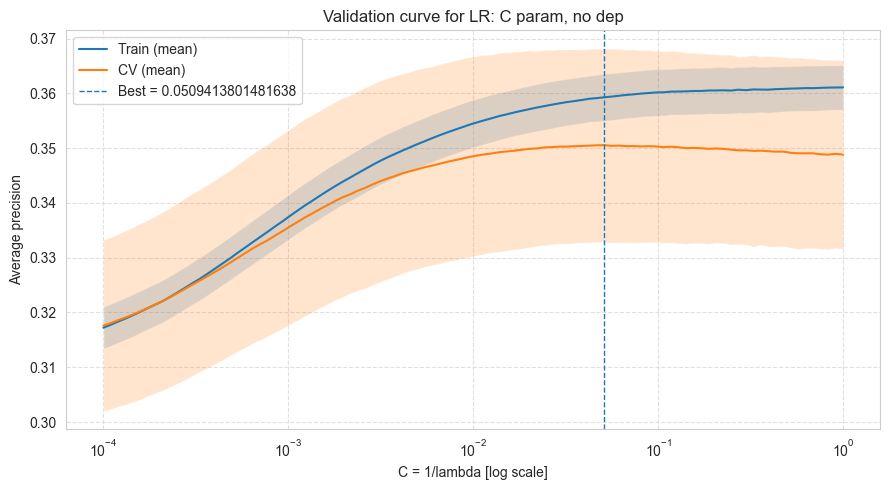

In [20]:
plot_fixed_param_curve(
    grid_lr,
    vary_key="model__C",
    title="Validation curve for LR: C param, no dep",
    xlabel="C = 1/lambda [log scale]",
    xscale="log",
    markers=None,
    save=True,
)

# Evaluation of LR Model


--- Validation metrics - LR - No departure --
Saved plot → img/classif_no_dep/conf_matrix\lr_conf_matrix_holdout_no_dep.png


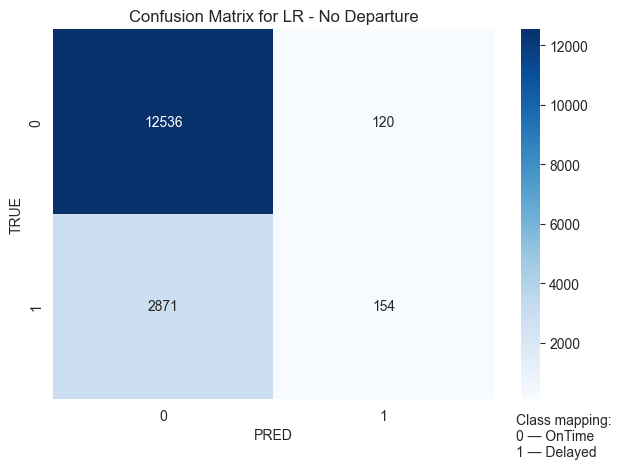

Saved plot → img/classif_no_dep/pr_curves\lr_pr_curve_holdout_no_dep.png


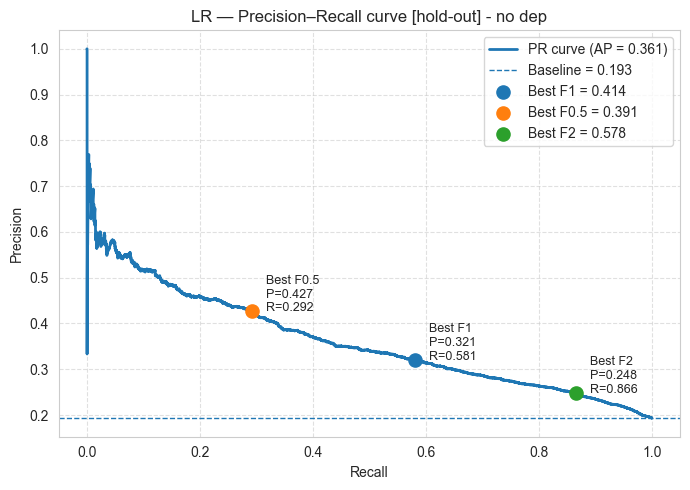

,LR
Accuracy,80.926
Precision,56.204
Recall,5.091
F1,0.093
Kappa,0.063
ROC_AUC,0.700
PR_AUC,0.361
CV_average_precision,0.351


In [21]:
lr_best_scores = model_evaluation('LR', clf_best_lr, X_valid, y_valid, tune_threshold=False, conf_matr=True, clas_report=False, pr_curve_plot=True, save_pr=True, save_conf=True)
lr_best_scores[f'CV_{SCORING_LR}'] = round(grid_lr.best_score_, 3)
lr_best_scores.T

## saving model

In [22]:
# save model
save_model("LR", grid_lr, lr_best_scores, SCORING_LR, RANDOM_STATE_LR, CV_SPLITS_LR)

## LR with SMOTE/class balance

In [24]:
pipe_lr = make_pipe(LogisticRegression(), use_smote=False, use_fs=False)

lr_grid_params_bal = {
        # default
        "model__solver": ["lbfgs"],
        "model__max_iter": [3000],
        "model__class_weight": ['balanced'],
        "model__random_state": [RANDOM_STATE_LR],
        
        # Tune 
        "model__penalty": ["l2"],
        "model__C": np.logspace(-4, 0, 100),
    }

# Training
grid_lr_bal = GridSearchCV(estimator=pipe_lr, param_grid=lr_grid_params_bal,
                       scoring=SCORING_LR, cv=cv_lr, return_train_score=True,
                       n_jobs=-1, verbose=1)

grid_lr_bal.fit(X_train, y_train)

clf_best_lr_bal = grid_lr_bal.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits



--- Validation metrics - LR_bal - No departure --
Saved plot → img/classif_no_dep/conf_matrix\lr_bal_conf_matrix_holdout_no_dep.png


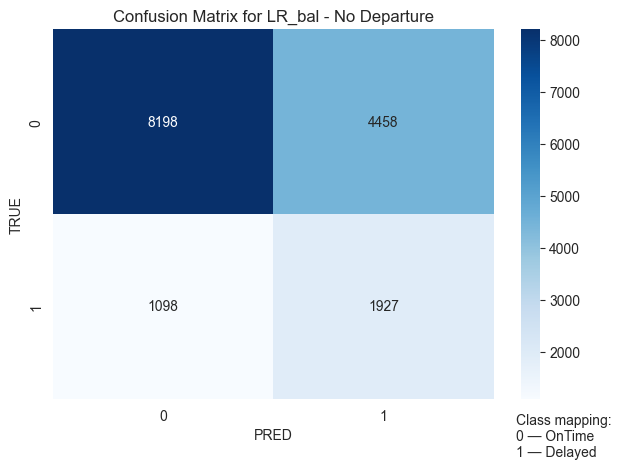

Saved plot → img/classif_no_dep/pr_curves\lr_bal_pr_curve_holdout_no_dep.png


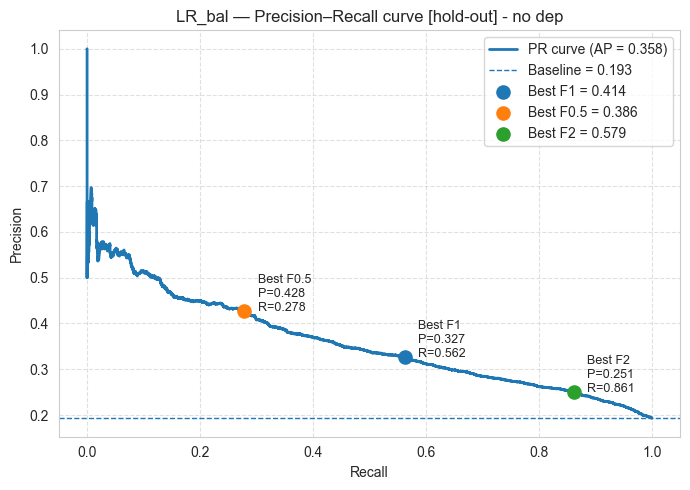

,LR_bal
Accuracy,64.569
Precision,30.180
Recall,63.702
F1,0.410
Kappa,0.200
ROC_AUC,0.700
PR_AUC,0.358
CV_average_precision,0.348


In [25]:
lr_best_scores_bal = model_evaluation('LR_bal', clf_best_lr_bal, X_valid, y_valid, tune_threshold=False, conf_matr=True, clas_report=False, pr_curve_plot=True, save_pr=True, save_conf=True)
lr_best_scores_bal[f'CV_{SCORING_LR}'] = round(grid_lr_bal.best_score_, 3)
lr_best_scores_bal.T

Saved plot → img/classif_no_dep/val_curves\validation_curve_for_lr_balanced_c_param_-_no_bal_NO_Dep_model__C.png


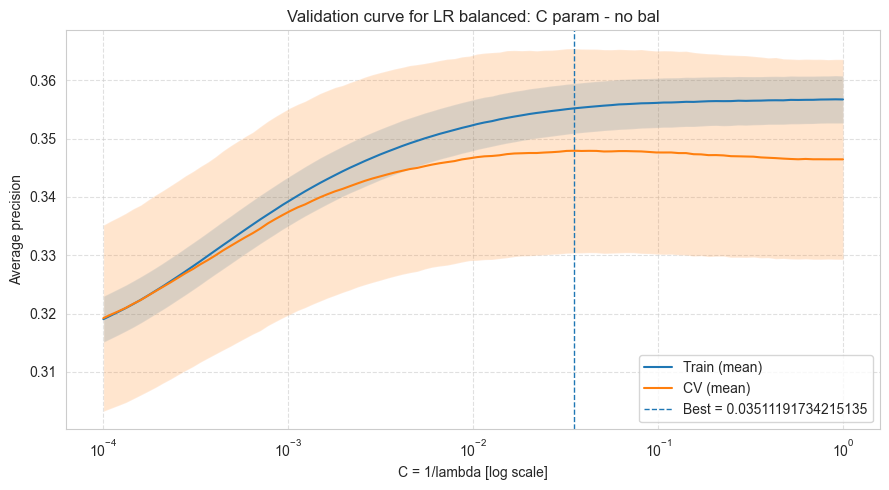

In [26]:
plot_fixed_param_curve(
    grid_lr_bal,
    vary_key="model__C",
    title="Validation curve for LR balanced: C param - no bal",
    xlabel="C = 1/lambda [log scale]",
    xscale="log",
    markers=None,
    save=True,
)

## saving lr_bal model


In [27]:
# save model
save_model("LR_bal", grid_lr_bal, lr_best_scores_bal, SCORING_LR, RANDOM_STATE_LR, CV_SPLITS_LR)

---

# Decision Tree Tuned

---

In [28]:
SCORING_DT = "average_precision"
CV_SPLITS_DT = 5
RANDOM_STATE_DT = 33

cv_dt = StratifiedKFold(n_splits=CV_SPLITS_DT, shuffle=True, random_state=RANDOM_STATE_DT)

pipe_dt = make_pipe(DecisionTreeClassifier(), use_smote=False, use_fs=False)

dt_grid_params = {
        # Default
        "model__criterion": ['gini'],
        "model__class_weight": [None],
        "model__random_state": [RANDOM_STATE_DT],
        
        # For tune
        "model__max_depth": np.arange(6, 30, 1),
        "model__min_samples_split": [100, 200, 300, 350],
        "model__min_samples_leaf": [110, 200, 220],
    }

grid_dt = GridSearchCV(estimator=pipe_dt, param_grid=dt_grid_params,
                       scoring=SCORING_DT, cv=cv_dt, return_train_score=True,
                       n_jobs=-1, verbose=1)

grid_dt.fit(X_train, y_train)

clf_best_dt = grid_dt.best_estimator_

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


## validation curves

Saved plot → img/classif_no_dep/val_curves\validation_curve_for_dt_max_depth_-_no_dep_NO_Dep_model__max_depth.png


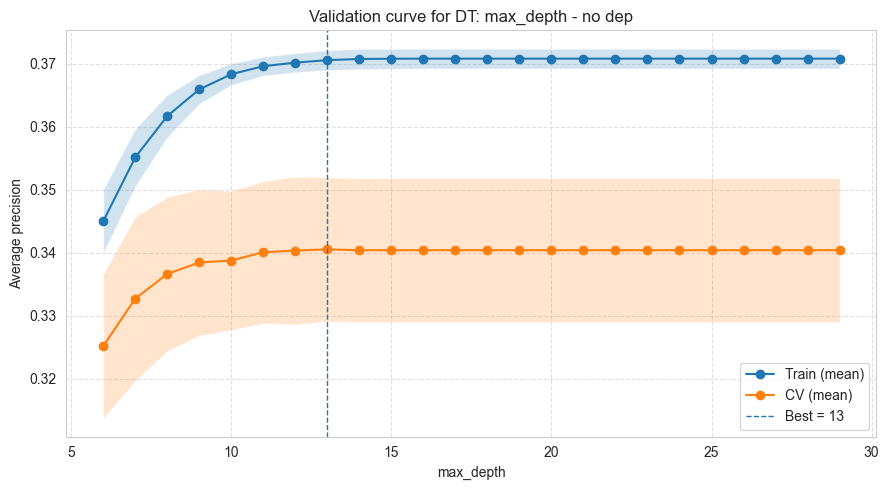

Saved plot → img/classif_no_dep/val_curves\validation_curve_for_dt_min_samples_split_-_no_dep_NO_Dep_model__min_samples_split.png


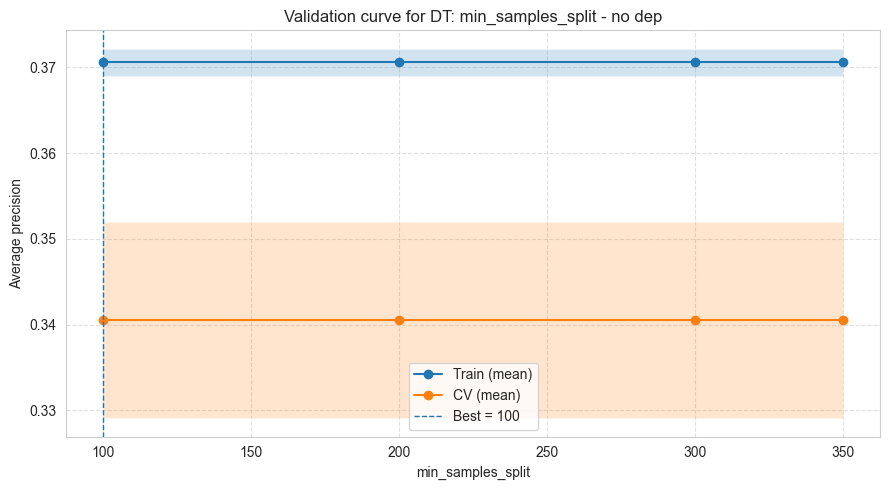

Saved plot → img/classif_no_dep/val_curves\validation_curve_for_dt_min_samples_leaf_-_no_dep_NO_Dep_model__min_samples_leaf.png


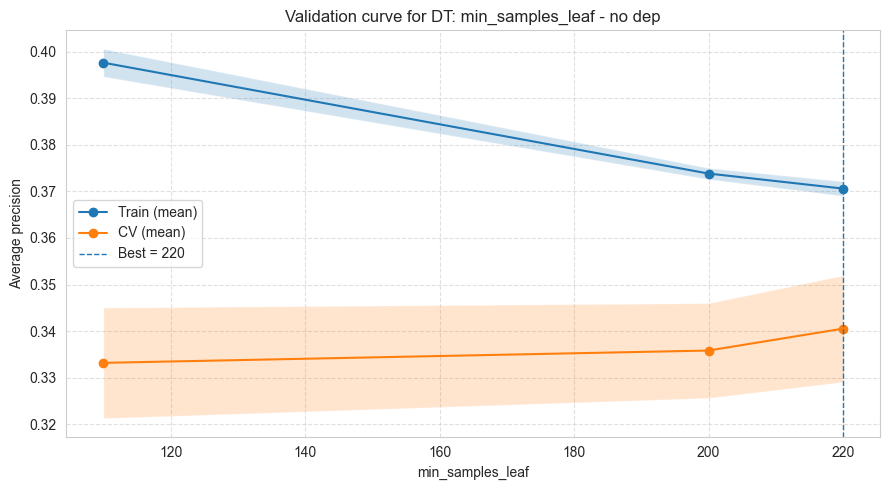

In [29]:
# 1) max_depth curve (fix others at best)
plot_fixed_param_curve(
    grid_dt,
    vary_key="model__max_depth",
    title="Validation curve for DT: max_depth - no dep",
    xlabel="max_depth",
    save=True
)

# 2) min_samples_split curve (fix others at best)
plot_fixed_param_curve(
    grid_dt,
    vary_key="model__min_samples_split",
    title="Validation curve for DT: min_samples_split - no dep",
    xlabel="min_samples_split",
    save=True
)

# 2) min_samples_leaf curve (fix others at best)
plot_fixed_param_curve(
    grid_dt,
    vary_key="model__min_samples_leaf",
    title="Validation curve for DT: min_samples_leaf - no dep",
    xlabel="min_samples_leaf",
    save=True
)

# Evaluation of DT model


--- Validation metrics - DT - No departure --
Saved plot → img/classif_no_dep/conf_matrix\dt_conf_matrix_holdout_no_dep.png


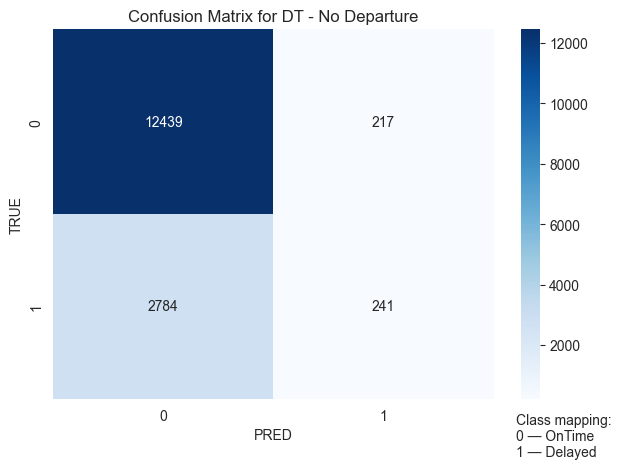

Saved plot → img/classif_no_dep/pr_curves\dt_pr_curve_holdout_no_dep.png


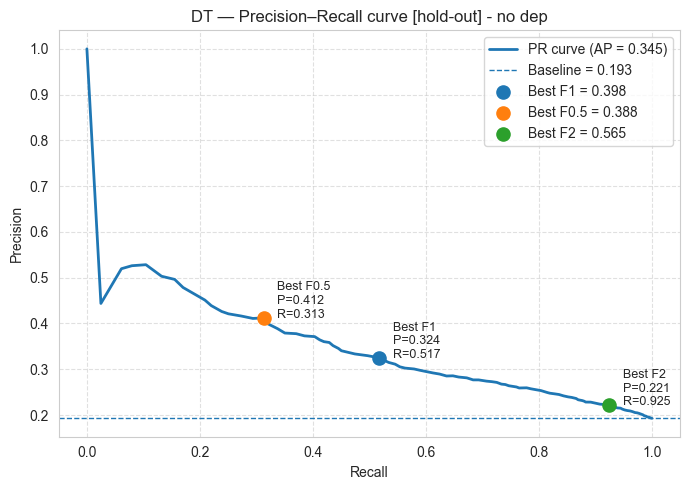

,DT
Accuracy,80.862
Precision,52.620
Recall,7.967
F1,0.138
Kappa,0.092
ROC_AUC,0.685
PR_AUC,0.345
CV_average_precision,0.341


In [30]:
dt_best_scores = model_evaluation('DT', clf_best_dt, X_valid, y_valid, tune_threshold=False,conf_matr=True, clas_report=False, pr_curve_plot=True, save_pr=True, save_conf=True)
dt_best_scores[f'CV_{SCORING_DT}'] = round(grid_dt.best_score_, 3)
dt_best_scores.T

In [31]:
path = save_dtreeviz_tree_from_pipeline(
    clf_best_dt,
    X_train, y_train,
    class_names=("OnTime","Delayed"),
    target_name="ArrDel15",
    save_path="img/trees_no_dep/No_Dep_dtree_best_3.svg",
    max_depth=3
)
print("Saved:", path)

Saved: img/trees_no_dep/No_Dep_dtree_best_3.svg


In [32]:
path2 = save_dtreeviz_tree_from_pipeline(
    clf_best_dt,
    X_train, y_train,
    class_names=("OnTime","Delayed"),
    target_name="ArrDel15",
    save_path="img/trees_no_dep/No_Dep_dtree_best_MAX.svg",
    max_depth=100
)
print("Saved:", path2)

Saved: img/trees_no_dep/No_Dep_dtree_best_MAX.svg


## saving dt model

In [33]:
# save model
save_model("DT", grid_dt, dt_best_scores, SCORING_DT, RANDOM_STATE_DT, CV_SPLITS_DT)

## DT with SMOTE/Balanced classes

In [34]:
pipe_dt_bal = make_pipe(DecisionTreeClassifier(), use_smote=False, use_fs=False)

dt_grid_params_bal = {
        # Default
        "model__criterion": ['gini'],
        "model__class_weight": ['balanced'],
        "model__random_state": [RANDOM_STATE_DT],
        
        # For tune
        "model__max_depth": np.arange(6, 30, 1),
        "model__min_samples_split": [100, 200, 300, 350],
        "model__min_samples_leaf": [110, 200, 220],
    }

grid_dt_bal = GridSearchCV(estimator=pipe_dt_bal, param_grid=dt_grid_params_bal,
                       scoring=SCORING_DT, cv=cv_dt, return_train_score=True,
                       n_jobs=-1, verbose=1)

grid_dt_bal.fit(X_train, y_train)

clf_best_dt_bal = grid_dt_bal.best_estimator_

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


Saved plot → img/classif_no_dep/val_curves\validation_curve_for_dt_balanced_max_depth_-_no_dep_NO_Dep_model__max_depth.png


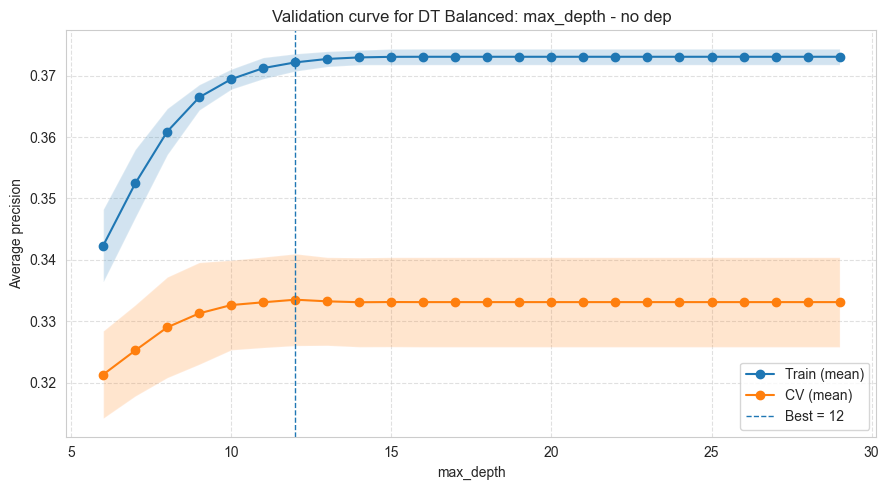

Saved plot → img/classif_no_dep/val_curves\validation_curve_for_dt_balanced_min_samples_split_-_no_dep_NO_Dep_model__min_samples_split.png


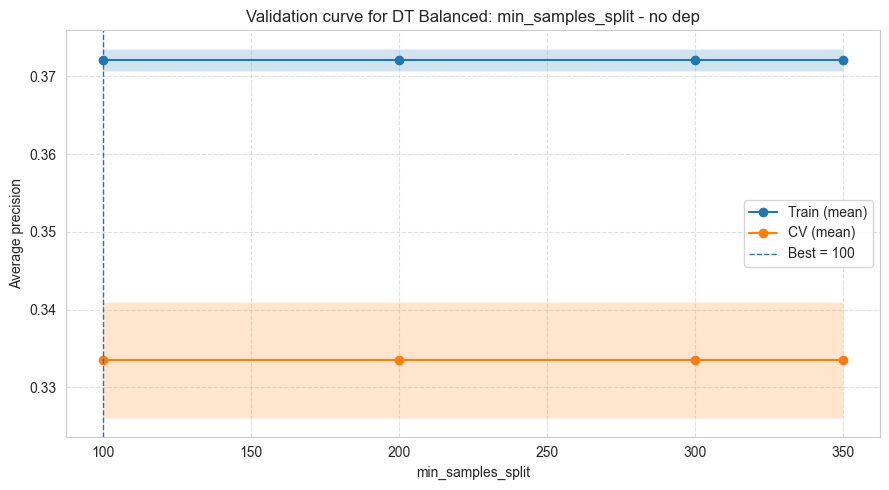

Saved plot → img/classif_no_dep/val_curves\validation_curve_for_dt_balanced_min_samples_leaf_-_no_dep_NO_Dep_model__min_samples_leaf.png


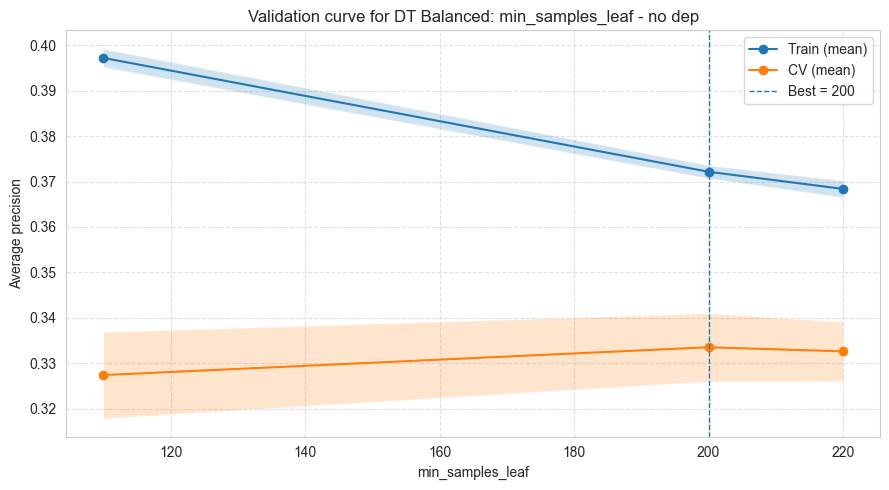

In [35]:
# 1) max_depth curve (fix others at best)
plot_fixed_param_curve(
    grid_dt_bal,
    vary_key="model__max_depth",
    title="Validation curve for DT Balanced: max_depth - no dep",
    xlabel="max_depth",
    save=True
)

# 2) min_samples_split curve (fix others at best)
plot_fixed_param_curve(
    grid_dt_bal,
    vary_key="model__min_samples_split",
    title="Validation curve for DT Balanced: min_samples_split - no dep",
    xlabel="min_samples_split",
    save=True
)

# 2) min_samples_leaf curve (fix others at best)
plot_fixed_param_curve(
    grid_dt_bal,
    vary_key="model__min_samples_leaf",
    title="Validation curve for DT Balanced: min_samples_leaf - no dep",
    xlabel="min_samples_leaf",
    save=True
)


--- Validation metrics - DT_bal - No departure --
Saved plot → img/classif_no_dep/conf_matrix\dt_bal_conf_matrix_holdout_no_dep.png


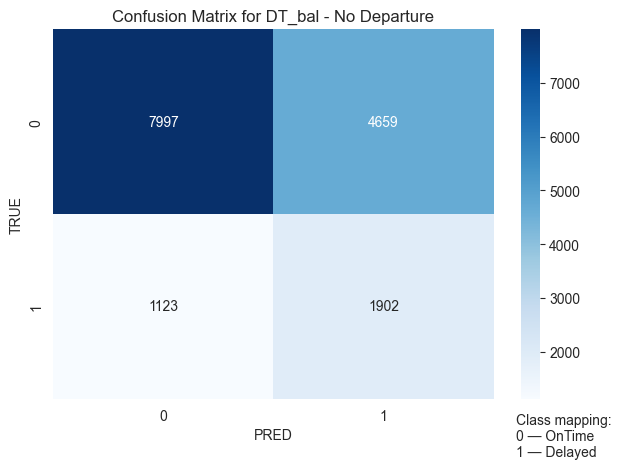

Saved plot → img/classif_no_dep/pr_curves\dt_bal_pr_curve_holdout_no_dep.png


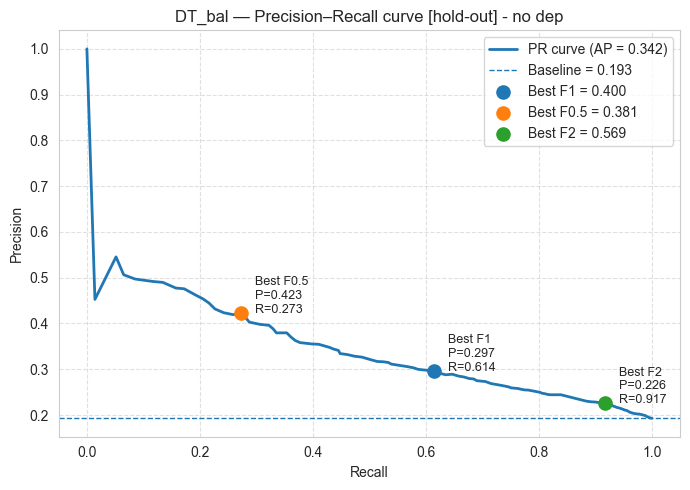

,DT_bal
Accuracy,63.127
Precision,28.989
Recall,62.876
F1,0.397
Kappa,0.180
ROC_AUC,0.683
PR_AUC,0.342
CV_average_precision,0.334


In [36]:
dt_best_scores_bal = model_evaluation('DT_bal', clf_best_dt_bal, X_valid, y_valid, tune_threshold=False,conf_matr=True, clas_report=False, pr_curve_plot=True, save_pr=True, save_conf=True)
dt_best_scores_bal[f'CV_{SCORING_DT}'] = round(grid_dt_bal.best_score_, 3)
dt_best_scores_bal.T

In [37]:
path3 = save_dtreeviz_tree_from_pipeline(
    clf_best_dt_bal,
    X_train, y_train,
    class_names=("OnTime","Delayed"),
    target_name="ArrDel15",
    save_path="img/trees_no_dep/No_Dep_dtree_bal_best_3.svg",
    max_depth=3
)
print("Saved:", path3)

Saved: img/trees_no_dep/No_Dep_dtree_bal_best_3.svg


In [38]:
path4 = save_dtreeviz_tree_from_pipeline(
    clf_best_dt_bal,
    X_train, y_train,
    class_names=("OnTime","Delayed"),
    target_name="ArrDel15",
    save_path="img/trees_no_dep/No_Dep_dtree_bal_best_MAX.svg",
    max_depth=100
)
print("Saved:", path4)

Saved: img/trees_no_dep/No_Dep_dtree_bal_best_MAX.svg


## saving dt_bal model

In [39]:
# save model
save_model("DT_bal", grid_dt_bal, dt_best_scores_bal, SCORING_DT, RANDOM_STATE_DT, CV_SPLITS_DT)

---

# Random Forest Tuned

---

In [40]:
SCORING_RF = "average_precision"
CV_SPLITS_RF = 5
RANDOM_STATE_RF = 33

cv_rf = StratifiedKFold(n_splits=CV_SPLITS_RF, shuffle=True, random_state=RANDOM_STATE_RF)

pipe_rf = make_pipe(RandomForestClassifier(), use_smote=False, use_fs=False)

rf_grid_params = {
        # Default
        "model__class_weight": [None],
        "model__random_state": [RANDOM_STATE_RF],
        "model__n_jobs": [-1],
        
        # For tune
        "model__n_estimators": [4, 5, 10, 30, 40, 50, 100],
        "model__max_depth": [None],
        "model__min_samples_split": [2],
        "model__min_samples_leaf": [2],
    }

grid_rf = GridSearchCV(estimator=pipe_rf, param_grid=rf_grid_params,
                       scoring=SCORING_RF, cv=cv_rf, return_train_score=True,
                       n_jobs=-1, verbose=1)

grid_rf.fit(X_train, y_train)

clf_best_rf = grid_rf.best_estimator_

Fitting 5 folds for each of 7 candidates, totalling 35 fits


Saved plot → img/classif_no_dep/val_curves\validation_curve_for_rf_number_of_trees_-_no_dep_NO_Dep_model__n_estimators.png


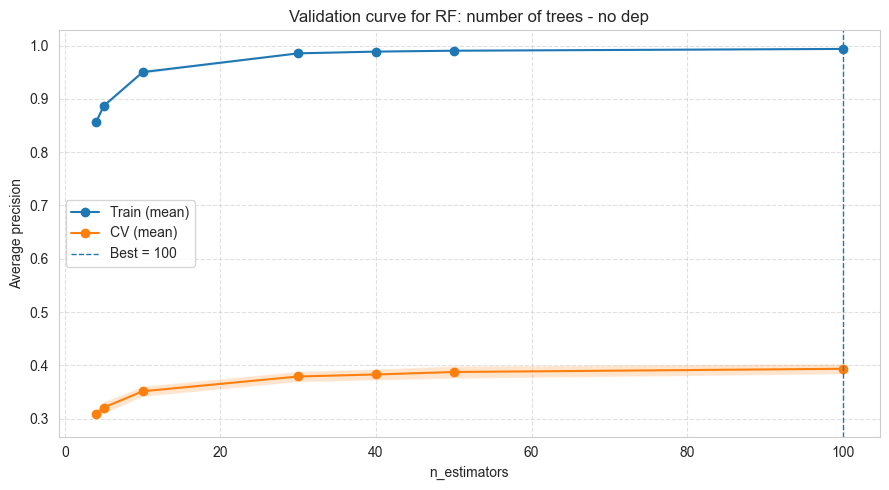

In [41]:
# n_estimators curve 
plot_fixed_param_curve(
    grid_rf,
    vary_key="model__n_estimators",
    title="Validation curve for RF: number of trees - no dep",
    xlabel="n_estimators",
    save=True
)

# Evaluation of RF Model


--- Validation metrics - RF - No departure --
Saved plot → img/classif_no_dep/conf_matrix\rf_conf_matrix_holdout_no_dep.png


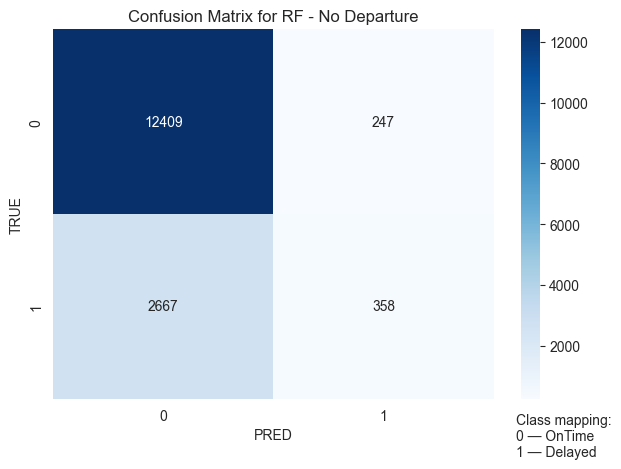

Saved plot → img/classif_no_dep/pr_curves\rf_pr_curve_holdout_no_dep.png


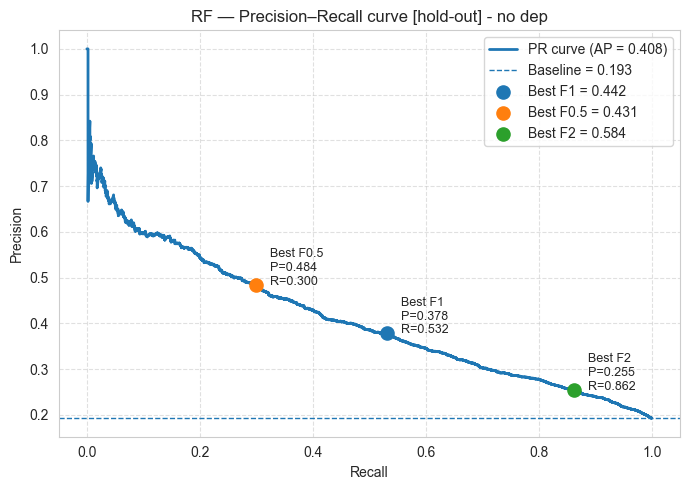

,RF
Accuracy,81.417
Precision,59.174
Recall,11.835
F1,0.197
Kappa,0.142
ROC_AUC,0.725
PR_AUC,0.408
CV_average_precision,0.393


In [42]:
rf_best_scores = model_evaluation('RF', clf_best_rf, X_valid, y_valid, conf_matr=True, tune_threshold=False, clas_report=False, pr_curve_plot=True, save_pr=True, save_conf=True)
rf_best_scores[f'CV_{SCORING_RF}'] = round(grid_rf.best_score_, 3)
rf_best_scores.T

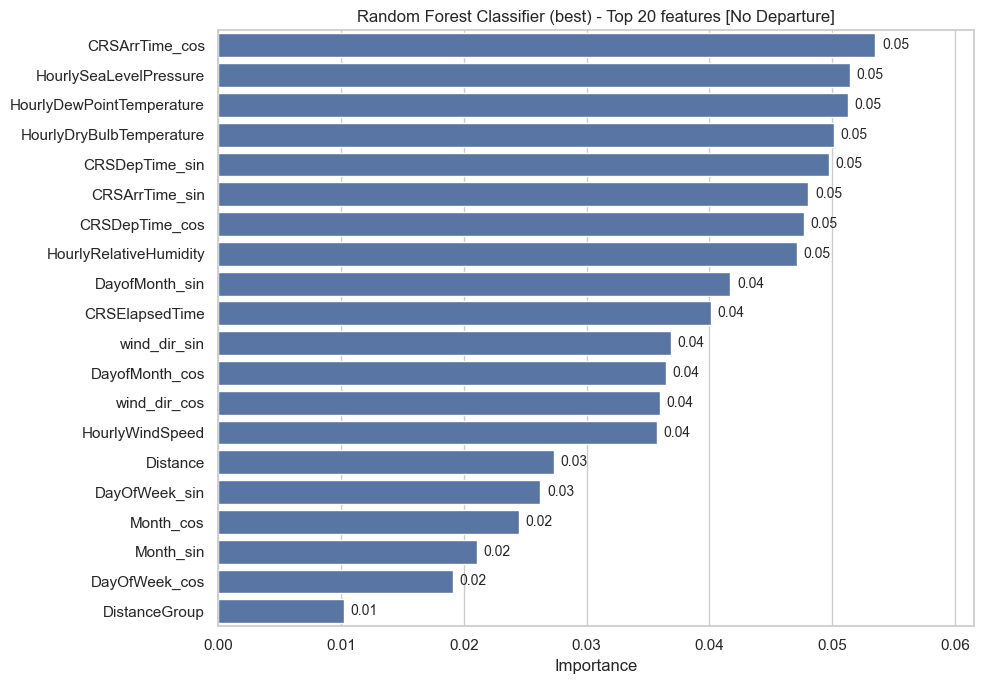

In [43]:
fig, ax, fi_df = plot_feature_importance(
     clf_best_rf,
     feature_names=X_train_encoded_features,
     top_n=20,
     title="Random Forest Classifier (best) - Top 20 features [No Departure]",
     save_path="img/classif_no_dep/feat_imp/feat_imp_class_rf_top20_no_dep.png",
     value_fmt="{:.2f}", 
)
plt.show()

# save model

In [44]:
# save model
save_model("RF", grid_rf, rf_best_scores, SCORING_RF, RANDOM_STATE_RF, CV_SPLITS_RF)

## RF with SMOTE/balanced classes

In [45]:
pipe_rf_bal = make_pipe(RandomForestClassifier(), use_smote=False, use_fs=False)

rf_grid_params_bal = {
        # Default
        "model__class_weight": ['balanced'],
        "model__random_state": [RANDOM_STATE_RF],
        "model__n_jobs": [-1],
        
        # For tune
        "model__n_estimators": [5, 10, 30, 40, 50, 100, 500],
        "model__max_depth": [None],
        "model__min_samples_split": [2],
        "model__min_samples_leaf": [2],
    }

grid_rf_bal = GridSearchCV(estimator=pipe_rf_bal, param_grid=rf_grid_params_bal,
                       scoring=SCORING_RF, cv=cv_rf, return_train_score=True,
                       n_jobs=-1, verbose=1)

grid_rf_bal.fit(X_train, y_train)

clf_best_rf_bal = grid_rf_bal.best_estimator_

Fitting 5 folds for each of 7 candidates, totalling 35 fits


Saved plot → img/classif_no_dep/val_curves\validation_curve_for_rf_balanced_number_of_trees_-_no_dep_NO_Dep_model__n_estimators.png


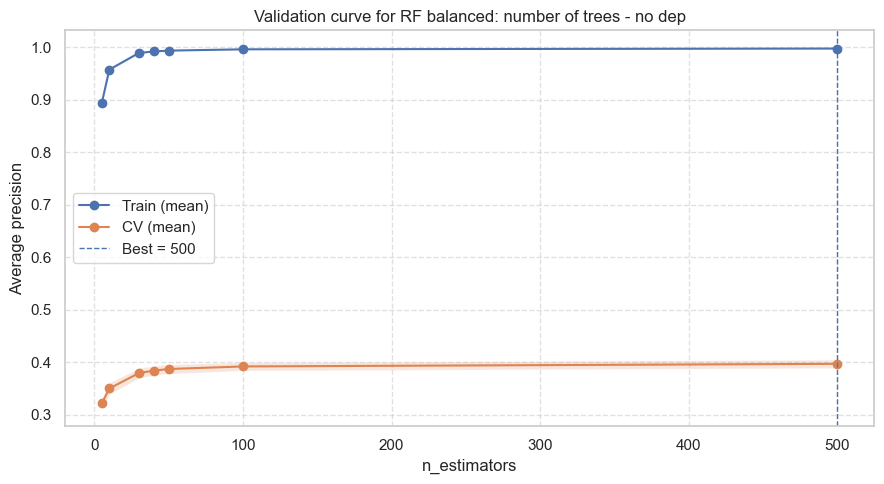

In [46]:
# 1) n_estimators curve 
plot_fixed_param_curve(
    grid_rf_bal,
    vary_key="model__n_estimators",
    title="Validation curve for RF balanced: number of trees - no dep",
    xlabel="n_estimators",
    save=True
)


--- Validation metrics - RF_bal - No departure --
Saved plot → img/classif_no_dep/conf_matrix\rf_bal_conf_matrix_holdout_no_dep.png


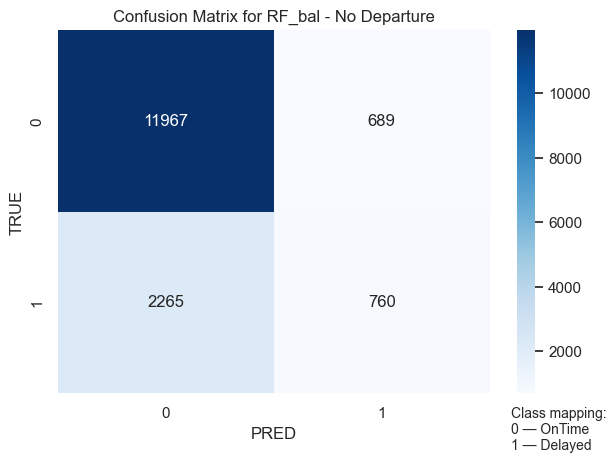

Saved plot → img/classif_no_dep/pr_curves\rf_bal_pr_curve_holdout_no_dep.png


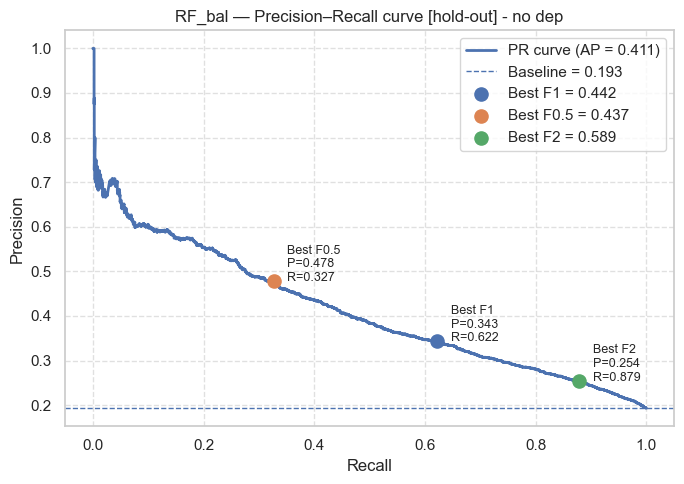

In [47]:
rf_best_scores_bal = model_evaluation('RF_bal', clf_best_rf_bal, X_valid, y_valid, tune_threshold=False, conf_matr=True, clas_report=False, pr_curve_plot=True, save_pr=True, save_conf=True)
rf_best_scores_bal[f'CV_{SCORING_RF}'] = round(grid_rf_bal.best_score_, 3)
rf_best_scores_bal.T.iloc

## saving rf_bal model

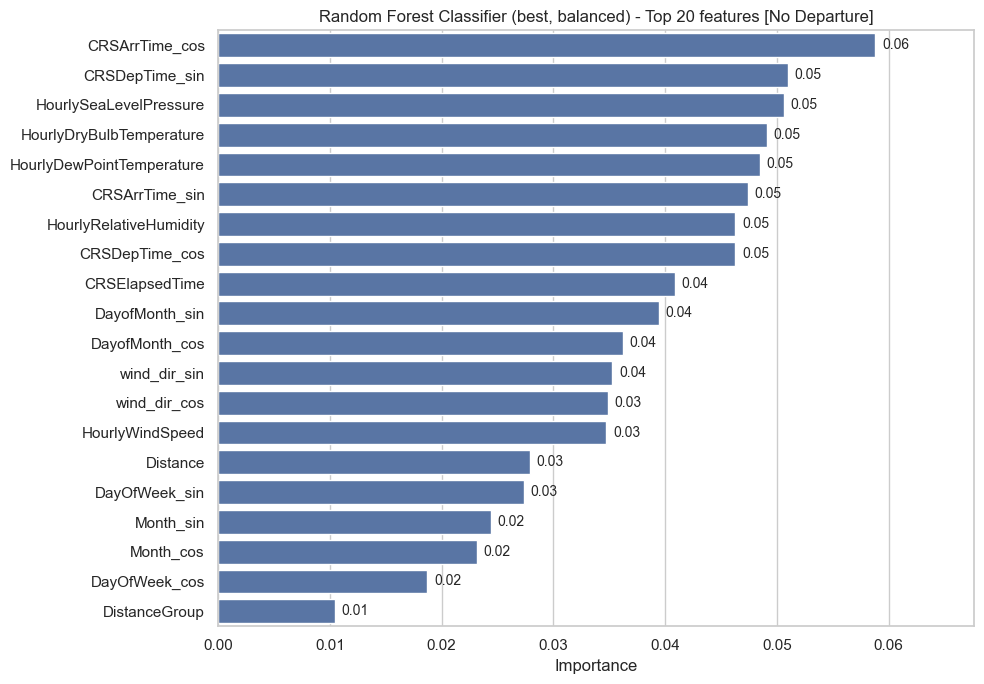

In [48]:
fig, ax, fi_df = plot_feature_importance(
     clf_best_rf_bal,
     feature_names=X_train_encoded_features, 
     top_n=20,
     title="Random Forest Classifier (best, balanced) - Top 20 features [No Departure]",
     save_path="img/classif_no_dep/feat_imp/feat_imp_class_rf_bal_top20_no_dep.png",
     value_fmt="{:.2f}",     
)
plt.show()

In [49]:
# save model
save_model("RF_bal", grid_rf_bal, rf_best_scores_bal, SCORING_RF, RANDOM_STATE_RF, CV_SPLITS_RF)

---

# XGBoost Tuned

---

## XGBoost Bayesian opimization (the most efficient)

In [57]:
from hyperopt import fmin, tpe, hp, STATUS_OK

xgb_grid_params_bayes = {
        "learning_rate": hp.quniform("eta", 0.005, 0.2, 0.005),
        "max_depth": hp.quniform("max_depth", 3, 20, 1),
        "min_child_weight": hp.quniform("min_child_weight", 1, 20, 1),
        "subsample": hp.quniform("subsample", 0.5, 1, 0.05),
        "gamma": hp.quniform("gamma", 0.1, 1, 0.01),
        "colsample_bytree": hp.quniform("colsample_bytree", 0.1, 1, 0.05)
    }

# Define the objective function to minimize
def objective(params):
    xgb_model = XGBClassifier(n_estimators=50, objective="binary:logistic", nthread=-1, verbosity=0)
    xgb_model.fit(X_train_encoded, y_train)
    y_pred_proba = xgb_model.predict_proba(X_valid_encoded)
    score = roc_auc_score(y_valid, y_pred_proba[:, 1])
    return {'loss': -score, 'status': STATUS_OK}

# Perform the optimization
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

best_params_xgb_bayes = fmin(objective, xgb_grid_params_bayes, algo=tpe.suggest, max_evals=200)
print("Best set of hyperparameters: ", best_params_xgb_bayes)
best_params_xgb_bayes["max_depth"] = int(best_params_xgb_bayes["max_depth"])
best_params_xgb_bayes["eval_metric"] = "logloss"
best_params_xgb_bayes["objective"] = "binary:logistic"
best_params_xgb_bayes["n_estimators"] = 1500
best_params_xgb_bayes["nthread"] = -1
best_params_xgb_bayes["verbosity"] = 0

#best_params["scale_pos_weight"] = ratio

print(f'Training XGBoost_Bayes with best params: \n{best_params_xgb_bayes}')
clf_best_xgb_bayes = XGBClassifier(**best_params_xgb_bayes).fit(X_train_encoded, y_train)

100%|██████████| 200/200 [00:23<00:00,  8.69trial/s, best loss: -0.7285296752724347]
Best set of hyperparameters:  {'colsample_bytree': np.float64(0.15000000000000002), 'eta': np.float64(0.14), 'gamma': np.float64(0.21), 'max_depth': np.float64(6.0), 'min_child_weight': np.float64(9.0), 'subsample': np.float64(0.75)}
Training XGBoost_Bayes with best params: 
{'colsample_bytree': np.float64(0.15000000000000002), 'eta': np.float64(0.14), 'gamma': np.float64(0.21), 'max_depth': 6, 'min_child_weight': np.float64(9.0), 'subsample': np.float64(0.75), 'eval_metric': 'logloss', 'objective': 'binary:logistic', 'n_estimators': 1500, 'nthread': -1, 'verbosity': 0}


## Evaluation of XGB Bayesian


--- Validation metrics - XGB_Bayes - No departure --
Saved plot → img/classif_no_dep/conf_matrix\xgb_bayes_conf_matrix_holdout_no_dep.png


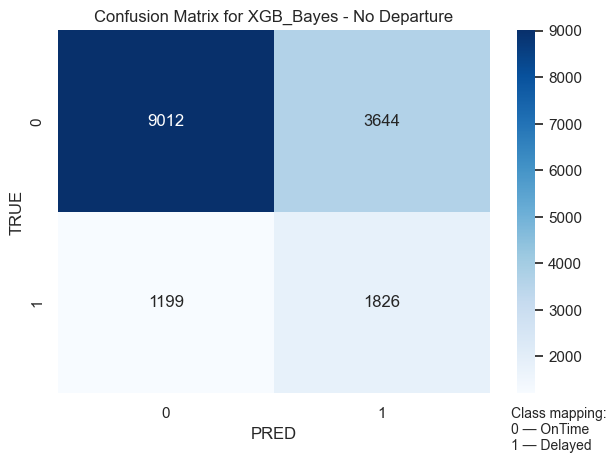

,XGB_Bayes
Accuracy,69.115
Precision,33.382
Recall,60.364
F1,0.430
Kappa,0.241
ROC_AUC,0.714
PR_AUC,0.401


In [58]:
xgb_bayes_best_scores = model_evaluation('XGB_Bayes', clf_best_xgb_bayes, X_valid_encoded, y_valid, tune_threshold=True, conf_matr=True, clas_report=False, save_conf=True)
xgb_bayes_best_scores.T

## XGBoost Bayes with SMOTE/Balanced classes

In [59]:
# Perform the optimization
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

best_params_xgb_bayes_bal = fmin(objective, xgb_grid_params_bayes, algo=tpe.suggest, max_evals=200)
print("Best set of hyperparameters: ", best_params_xgb_bayes_bal)
best_params_xgb_bayes_bal["max_depth"] = int(best_params_xgb_bayes_bal["max_depth"])
best_params_xgb_bayes_bal["eval_metric"] = "logloss"
best_params_xgb_bayes_bal["objective"] = "binary:logistic"
best_params_xgb_bayes_bal["n_estimators"] = 1500
best_params_xgb_bayes_bal["nthread"] = -1
best_params_xgb_bayes_bal["verbosity"] = 0

best_params_xgb_bayes_bal["scale_pos_weight"] = ratio

print(f'Training XGBoost_Bayes with best params: \n{best_params_xgb_bayes_bal}')
clf_best_xgb_bayes_bal = XGBClassifier(**best_params_xgb_bayes_bal).fit(X_train_encoded, y_train)

100%|██████████| 200/200 [00:24<00:00,  8.25trial/s, best loss: -0.7285296752724347]
Best set of hyperparameters:  {'colsample_bytree': np.float64(0.7000000000000001), 'eta': np.float64(0.2), 'gamma': np.float64(0.96), 'max_depth': np.float64(19.0), 'min_child_weight': np.float64(19.0), 'subsample': np.float64(0.8500000000000001)}
Training XGBoost_Bayes with best params: 
{'colsample_bytree': np.float64(0.7000000000000001), 'eta': np.float64(0.2), 'gamma': np.float64(0.96), 'max_depth': 19, 'min_child_weight': np.float64(19.0), 'subsample': np.float64(0.8500000000000001), 'eval_metric': 'logloss', 'objective': 'binary:logistic', 'n_estimators': 1500, 'nthread': -1, 'verbosity': 0, 'scale_pos_weight': np.float64(4.182646915188019)}



--- Validation metrics - XGB_Bayes_bal - No departure --
Saved plot → img/classif_no_dep/conf_matrix\xgb_bayes_bal_conf_matrix_holdout_no_dep.png


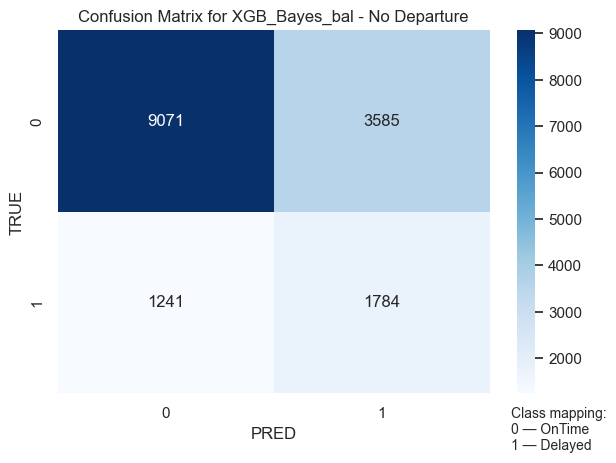

,XGB_Bayes_bal
Accuracy,69.224
Precision,33.228
Recall,58.975
F1,0.425
Kappa,0.237
ROC_AUC,0.709
PR_AUC,0.382


In [61]:
xgb_bayes_best_scores_bal = model_evaluation('XGB_Bayes_bal', clf_best_xgb_bayes_bal, X_valid_encoded, y_valid, tune_threshold=True, conf_matr=True, clas_report=False, save_conf=True)
xgb_bayes_best_scores_bal.T

## Randomized Search CV approach

In [62]:
SCORING_XGB = "average_precision"
CV_SPLITS_XGB = 5
RANDOM_STATE_XGB = 33

cv_xgb = StratifiedKFold(n_splits=CV_SPLITS_XGB, shuffle=True, random_state=RANDOM_STATE_XGB)

pipe_xgb = make_pipe(XGBClassifier(), use_smote=False, use_fs=False)

#ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xgb_grid_params = {
        # Default
        "model__n_estimators": [200],
        "model__objective": ["binary:logistic"],
        "model__scale_pos_weight": [None],
        "model__nthread": [-1],
        "model__verbosity": [0],
    
        # For tune
        "model__learning_rate": [0.05, 0.1, 0.15, 0.2, 0.25, 0.35, 0.4, 0.5, 0.6, 0.8],
        "model__max_depth": range(3, 30, 1),
        "model__min_child_weight": range(1, 30, 1),
        "model__subsample": [0.5, 0.6, 0.8, 0.9, 1.0],
        "model__gamma": [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0],
        "model__colsample_bytree": [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    }

grid_xgb = RandomizedSearchCV(estimator=pipe_xgb, param_distributions=xgb_grid_params,
                        scoring=SCORING_XGB, cv=cv_xgb, return_train_score=True,
                        n_jobs=-1, verbose=1, n_iter=150, random_state=RANDOM_STATE_XGB)

grid_xgb.fit(X_train, y_train)

clf_best_xgb = grid_xgb.best_estimator_

Fitting 5 folds for each of 150 candidates, totalling 750 fits



--- Validation metrics - XGB_CV - No departure --
Saved plot → img/classif_no_dep/conf_matrix\xgb_cv_conf_matrix_holdout_no_dep.png


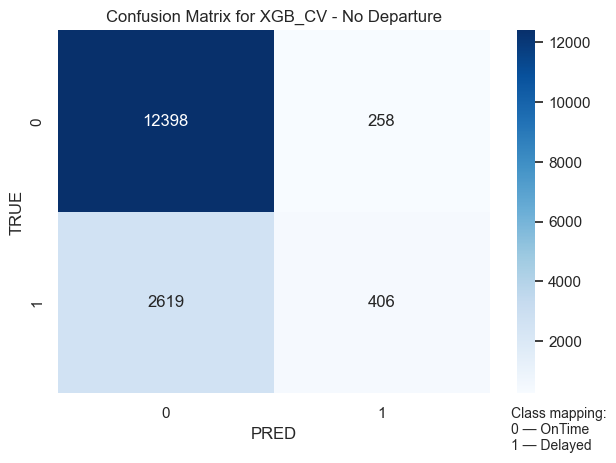

Saved plot → img/classif_no_dep/pr_curves\xgb_cv_pr_curve_holdout_no_dep.png


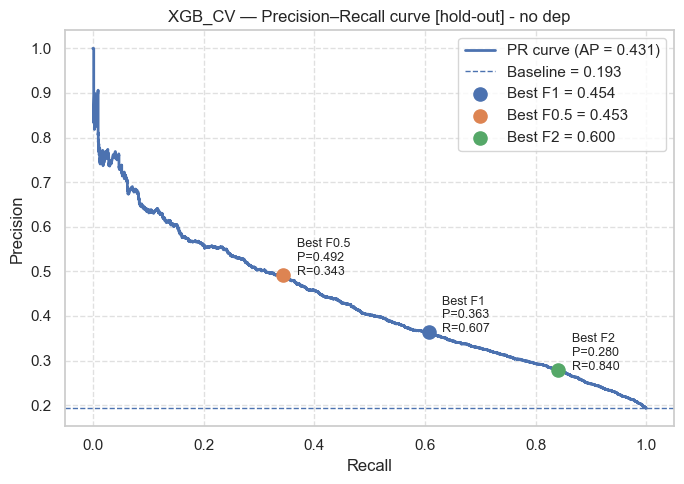

,XGB_CV
Accuracy,81.653
Precision,61.145
Recall,13.421
F1,0.220
Kappa,0.162
ROC_AUC,0.743
PR_AUC,0.431
CV_average_precision,0.410


In [63]:
xgb_best_scores = model_evaluation('XGB_CV', clf_best_xgb, X_valid, y_valid, tune_threshold=False, conf_matr=True, clas_report=False, pr_curve_plot=True, save_pr=True, save_conf=True)
xgb_best_scores[f'CV_{SCORING_XGB}'] = round(grid_xgb.best_score_, 3)
xgb_best_scores.T

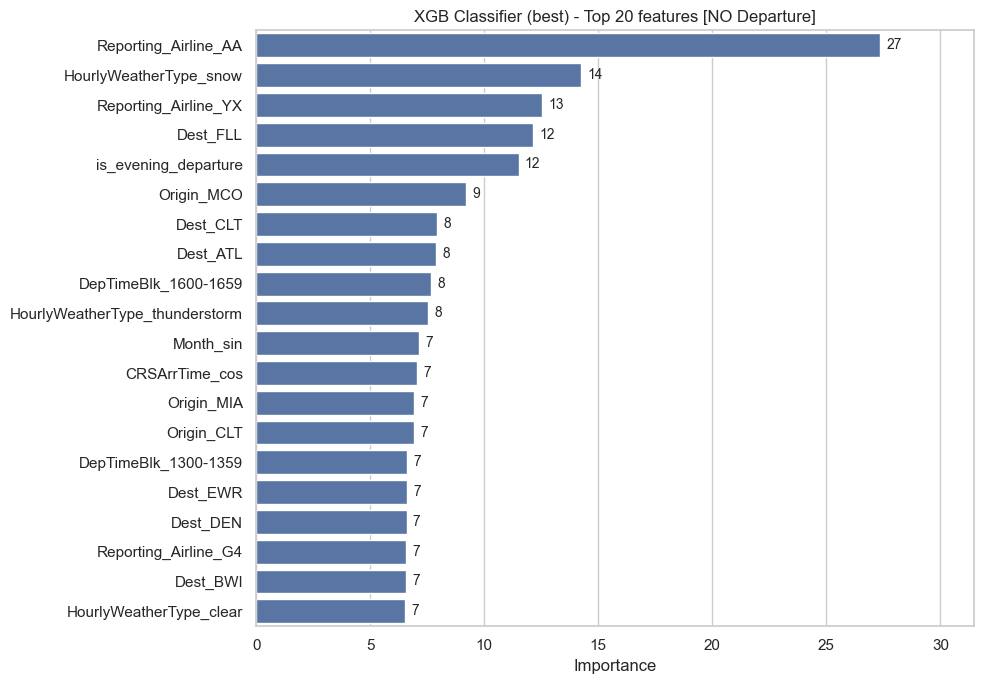

In [64]:
fig, ax, fi_df = plot_feature_importance(
     clf_best_xgb,
     feature_names=X_train_encoded_features,
     top_n=20,
     title="XGB Classifier (best) - Top 20 features [NO Departure]",
     save_path="img/classif_no_dep/feat_imp/xgb_top20_no_dep.png",
     value_fmt="{:.0f}",
)
plt.show()

In [65]:
path5 = save_dtreeviz_tree_from_pipeline(
    clf_best_xgb,
    X_train, y_train,
    class_names=("OnTime","Delayed"),
    target_name="ArrDel15",
    save_path="trees_no_dep/xgb[0]_3_class_best_no_dep.svg",
    max_depth=3,
    tree_index=0
)
print("Saved:", path5)

Saved: trees_no_dep/xgb[0]_3_class_best_no_dep.svg


In [66]:
path6 = save_dtreeviz_tree_from_pipeline(
    clf_best_xgb,
    X_train, y_train,
    class_names=("OnTime","Delayed"),
    target_name="ArrDel15",
    save_path="trees_no_dep/xgb[0]_MAX_class_best_no_dep.svg",
    max_depth=100,
    tree_index=0
)
print("Saved:", path6)

Saved: trees_no_dep/xgb[0]_MAX_class_best_no_dep.svg


## save xgb model

In [67]:
# save model
save_model("XGB", grid_xgb, xgb_best_scores, SCORING_XGB, RANDOM_STATE_XGB, CV_SPLITS_XGB)

## XGBoost with SMOTE/balanced classes

In [68]:
pipe_xgb_bal = make_pipe(XGBClassifier(), use_smote=False, use_fs=False)

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
xgb_grid_params_bal = {
        # Default
        "model__n_estimators": [50],
        "model__objective": ["binary:logistic"],
        "model__scale_pos_weight": [ratio],
        "model__nthread": [-1],
        "model__verbosity": [0],
    
        # For tune
        "model__learning_rate": [0.05, 0.1, 0.15, 0.2, 0.25, 0.35, 0.4, 0.5, 0.6, 0.8],
        "model__max_depth": range(3, 30, 1),
        "model__min_child_weight": range(1, 30, 1),
        "model__subsample": [0.5, 0.6, 0.8, 0.9, 1.0],
        "model__gamma": [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0],
        "model__colsample_bytree": [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    }

grid_xgb_bal = RandomizedSearchCV(estimator=pipe_xgb_bal, param_distributions=xgb_grid_params_bal,
                        scoring=SCORING_XGB, cv=cv_xgb, return_train_score=True,
                        n_jobs=-1, verbose=1, n_iter=100, random_state=RANDOM_STATE_XGB)

grid_xgb_bal.fit(X_train, y_train)

clf_best_xgb_bal = grid_xgb_bal.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits



--- Validation metrics - XGB_bal - No departure --
Saved plot → img/classif_no_dep/conf_matrix\xgb_bal_conf_matrix_holdout_no_dep.png


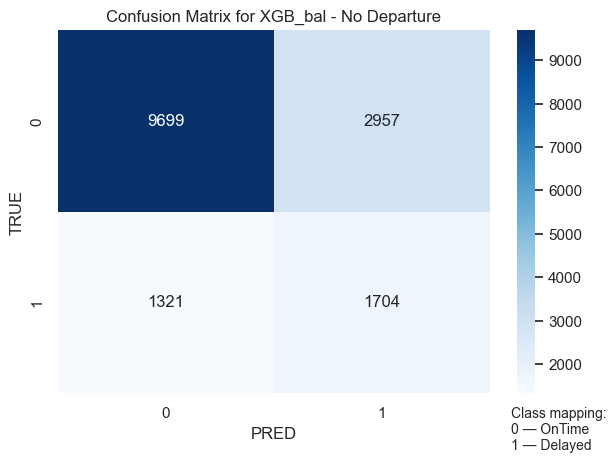

Saved plot → img/classif_no_dep/pr_curves\xgb_bal_pr_curve_holdout_no_dep.png


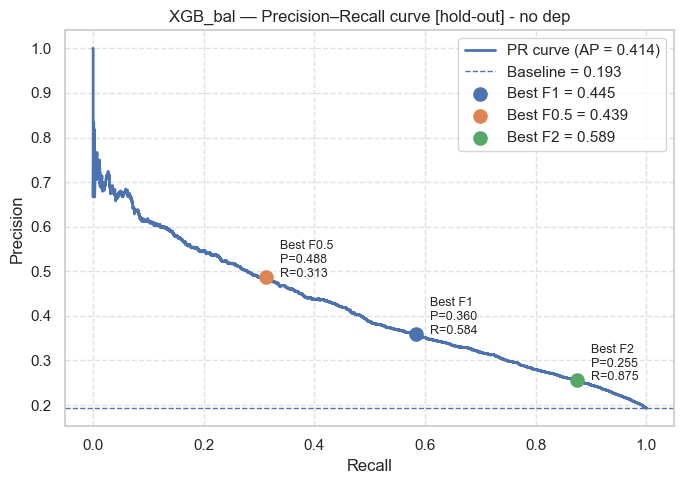

,XGB_bal
Accuracy,72.719
Precision,36.559
Recall,56.331
F1,0.443
Kappa,0.273
ROC_AUC,0.733
PR_AUC,0.414
CV_average_precision,0.402


In [72]:
xgb_best_scores_bal = model_evaluation('XGB_bal', clf_best_xgb_bal, X_valid, y_valid, tune_threshold=False, conf_matr=True, clas_report=False, pr_curve_plot=True, save_pr=True, save_conf=True)
xgb_best_scores_bal[f'CV_{SCORING_XGB}'] = round(grid_xgb_bal.best_score_, 3)
xgb_best_scores_bal.T

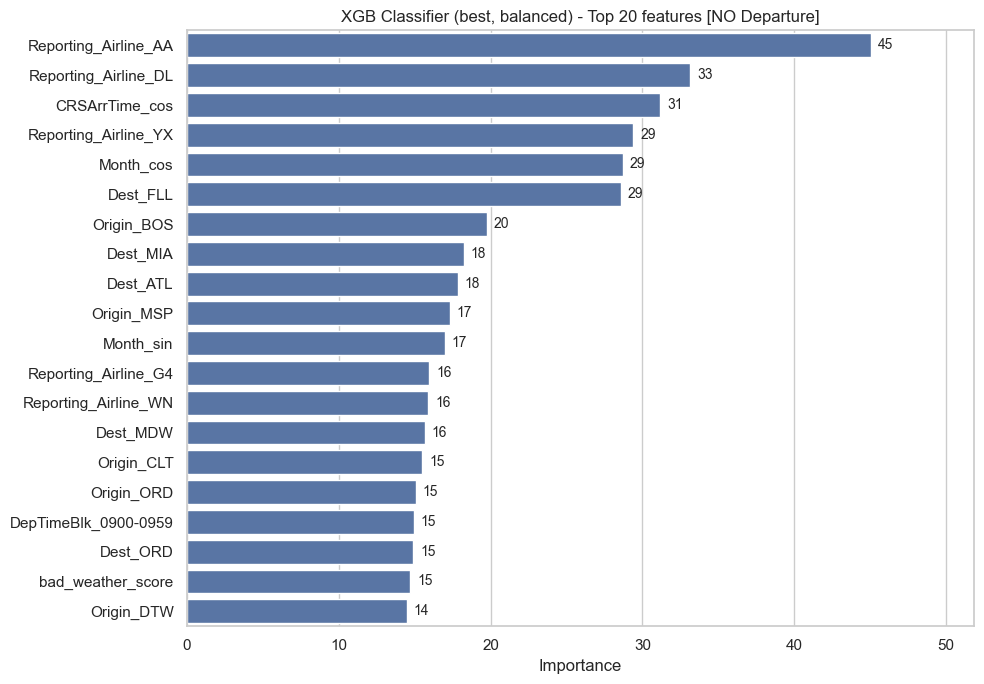

In [73]:
fig, ax, fi_df = plot_feature_importance(
     clf_best_xgb_bal,
     feature_names=X_train_encoded_features, 
     top_n=20,
     title="XGB Classifier (best, balanced) - Top 20 features [NO Departure]",
     save_path="img/classif_no_dep/feat_imp/xgb_bal_top20_no_dep.png",
     value_fmt="{:.0f}" 
)
plt.show()

In [74]:
path7 = save_dtreeviz_tree_from_pipeline(
    clf_best_xgb_bal,
    X_train, y_train,
    class_names=("OnTime","Delayed"),
    target_name="ArrDel15",
    save_path="trees_no_dep/xgb[3]_3_class_best_no_dep_bal.svg",
    max_depth=3,
    tree_index=0
)
print("Saved:", path7)

Saved: trees_no_dep/xgb[3]_3_class_best_no_dep_bal.svg


In [75]:
path8 = save_dtreeviz_tree_from_pipeline(
    clf_best_xgb_bal,
    X_train, y_train,
    class_names=("OnTime","Delayed"),
    target_name="ArrDel15",
    save_path="trees_no_dep/xgb[0]_MAX_class_best_no_dep_bal.svg",
    max_depth=100,
    tree_index=0
)
print("Saved:", path8)

Saved: trees_no_dep/xgb[0]_MAX_class_best_no_dep_bal.svg


# save xgb  balanced model

In [76]:
# save model
save_model("XGB_bal", grid_xgb_bal, xgb_best_scores_bal, SCORING_XGB, RANDOM_STATE_XGB, CV_SPLITS_XGB)

## Performance summary of all Tuned models
## WITHOUT Departure info (NO SMOTE)

In [77]:
lr = joblib.load('models/classif_no_dep/LR_NO_Dep_artifact.joblib')
lr = lr['scores_df']
lr_bal = joblib.load('models/classif_no_dep/LR_bal_NO_Dep_artifact.joblib')
lr_bal = lr_bal['scores_df']

dt = joblib.load('models/classif_no_dep/DT_NO_Dep_artifact.joblib')
dt = dt['scores_df']
dt_bal = joblib.load('models/classif_no_dep/DT_bal_NO_Dep_artifact.joblib')
dt_bal = dt_bal['scores_df']

rf = joblib.load('models/classif_no_dep/RF_NO_Dep_artifact.joblib')
rf = rf['scores_df']
rf_bal = joblib.load('models/classif_no_dep/RF_bal_NO_Dep_artifact.joblib')
rf_bal = rf_bal['scores_df']

xgb = joblib.load('models/classif_no_dep/XGB_NO_Dep_artifact.joblib')
xgb = xgb['scores_df']
xgb_bal = joblib.load('models/classif_no_dep/XGB_bal_NO_Dep_artifact.joblib')
xgb_bal = xgb_bal['scores_df']

In [78]:
scores_df_with_dep_no_bal = pd.concat([lr, dt, rf, xgb], axis=0)
scores_df_with_dep_no_bal = round(scores_df_with_dep_no_bal, 2)
scores_df_with_dep_no_bal.T

,LR,DT,RF,XGB_CV
Accuracy,80.93,80.86,81.42,81.65
Precision,56.20,52.62,59.17,61.14
Recall,5.09,7.97,11.84,13.42
F1,0.09,0.14,0.20,0.22
Kappa,0.06,0.09,0.14,0.16
ROC_AUC,0.70,0.68,0.72,0.74
PR_AUC,0.36,0.34,0.41,0.43
CV_average_precision,0.35,0.34,0.39,0.41


In [79]:
scores_df_with_dep_no_bal.to_csv('data/model_eval/scores_NO_dep_no_bal.csv', index=True)

---

## WITHOUT Departure info (weight balancing)

In [80]:
scores_df_with_dep_bal = pd.concat([lr_bal, dt_bal, rf_bal, xgb_bal], axis=0)
scores_df_with_dep_bal = round(scores_df_with_dep_bal, 2)
scores_df_with_dep_bal.T

,LR_bal,DT_bal,RF_bal,XGB_bal
Accuracy,64.57,63.13,81.16,72.72
Precision,30.18,28.99,52.45,36.56
Recall,63.70,62.88,25.12,56.33
F1,0.41,0.40,0.34,0.44
Kappa,0.20,0.18,0.24,0.27
ROC_AUC,0.70,0.68,0.73,0.73
PR_AUC,0.36,0.34,0.41,0.41
CV_average_precision,0.35,0.33,0.40,0.40


In [81]:
scores_df_with_dep_bal.to_csv('data/model_eval/scores_NO_dep_balanced.csv', index=True)

---